This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/IPUMS/non_normalized_cleaned_ipums_data.csv")

In [3]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,11000,16.000000,18.000000,0,1
1,38000,15.000000,23.000000,0,0
2,7000,13.000000,2.000000,0,0
3,2600,11.000000,0.000000,0,0
4,20800,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,22500,16.000000,13.000000,0,0
197752,4500,16.000000,11.000000,0,1
197753,37000,17.737673,19.262327,0,0
197754,1500,15.000000,13.000000,0,1


***

In [8]:
########### Code for years_of_educ CART ##########
cart_non_white = DecisionTreeClassifier(min_samples_leaf=20, random_state=rng)

In [10]:
cart_non_white.fit(X=pd.DataFrame(train_data.loc[:, 'incwage']), y=train_data.loc[:, 'years_of_educ'])

ValueError: Unknown label type: 'continuous'

In [11]:
np.unique(train_data.years_of_educ)

array([ 0.08522281,  2.95186709,  5.69144864,  7.75787121,  9.        ,
       10.        , 11.        , 12.        , 13.        , 14.        ,
       15.        , 16.        , 17.73767341])

In [13]:
len(np.unique(train_data.potential_experience))

298

***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [4]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_years_of_educ_,
                 mb_potential_experience_,
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]

    # generate and store number_synthetic_datasets synthetic datasets
    sXs = [pd.DataFrame(train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,'incwage']) for x in range(number_synthetic_datasets)]

    ####################################################################################################

    ########### Code for years_of_educ CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']], y=train_data.loc[:,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data['non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']], y=train_data.loc[:,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data['non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [5]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, _, _ = train_models(train_data=train_data,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         number_gmm_initializations=number_gmm_initializations,
                                         num_components_=int(num_components_),
                                         mb_non_white_=int(mb_non_white_),
                                         mb_sex_=int(mb_sex_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 300.99),
            "mb_sex_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -0.008198 | 226.2     | 75.89     | 132.7     |
| 2         | -1.587    | 266.8     | 225.5     | 147.8     |
| 3         | -670.8    | 95.94     | 162.9     | 43.19     |
| 4         | -2.551    | 246.3     | 257.2     | 58.99     |
| 5         | -234.1    | 79.03     | 143.4     | 53.72     |
| 6         | -98.56    | 244.6     | 253.5     | 56.68     |
| 7         | -201.1    | 250.1     | 265.7     | 64.42     |
| 8         | -0.0231   | 224.5     | 73.75     | 126.5     |
| 9         | -1.673e-0 | 223.7     | 83.81     | 127.0     |
| 10        | -0.00257  | 234.1     | 79.66     | 125.6     |
| 11        | -0.2529   | 259.9     | 236.5     | 150.1     |
| 12        | -0.1493   | 253.9     | 223.1     | 151.7     |
| 13        | -0.1225   | 228.6     | 72.97     | 127.4     |
| 14        | -0.164    | 254.5     | 224.1     | 137.6     |
| 15    

***

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

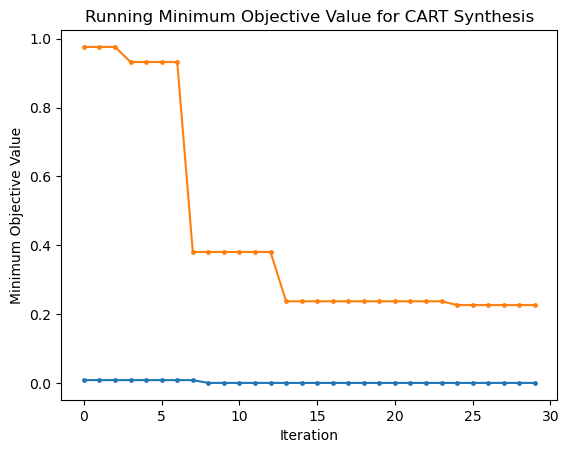

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -1.6728836523085288e-05,
 'params': {'mb_non_white_': 223.7158985052134,
  'mb_sex_': 83.81322194275862,
  'num_components_': 126.97223127395709}}

***

Generate 20 synthetic datasets.

In [12]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_non_white_=int(best_params['params']['mb_non_white_']))

In [13]:
np.mean(pmse_ratios)

0.9798335502720825

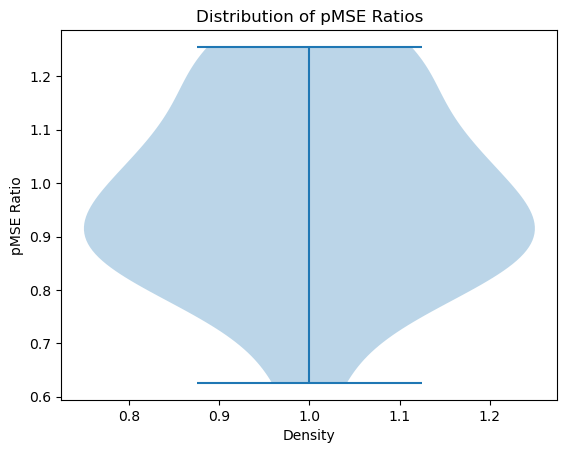

In [14]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [15]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/gmm_and_cart.pkl','wb') as f:
    pickle.dump(GMM,f)

***

In [ ]:
full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [ ]:
# load
with open('../Results/IPUMS/Models/gmm_and_cart.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [4]:
prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [5]:
prior

0.14195270939946197

In [ ]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [ ]:
deltas = np.linspace(0.001, 0.1, 3)

In [ ]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***